In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
from typing import Any, Dict

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
from torch_sparse import SparseTensor
from jaxtyping import Float, Integer
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import os

from src.graph_models.csbm import CSBM
from src.models.common import get_diffusion
from src.models.ntk import NTK
from src.models.ntk_old import NTK_OLD
from src.attacks import create_attack
from common import configure_hardware, get_graph, \
    count_edges_for_idx, calc_kernel_means, plot_ntk_model_diff, plot_ntk_model_acc
from src import utils

from sklearn.kernel_ridge import KernelRidge 
import seaborn as sns

In [130]:
# Data
data_dict = dict(
    classes = 2,
    n = 1000,
    n_per_class_trn = 300,
    n_per_class_labeled = 300,
    sigma = 1,
    avg_within_class_degree = 1.58 * 2, #0.05 * 999 / 2, #1.58 * 2,
    avg_between_class_degree =  0.37 * 2, #0.03 * 999 / 2, #0.37 * 2,
)
K = 1
seed = 1
seed_l = [seed for seed in range(1)]
# Model
model_dict_gcn = {
    "label": "GCN",
    "model": "GCN",
    "normalization": "row_normalization",
    "depth": 2,
}
model_dict_sym_gcn = {
    "label": "GCN_sym",
    "model": "GCN",
    "normalization": "sym_normalization",
    "depth": 2,
}
model_dict_softmedoid = {
    "label": "SoftM_T1",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 1,
    "T": 2
}
model_dict_softmedoid5 = {
    "label": "SoftM_T5",
    "model": "SoftMedoid",
    "normalization": "row_normalization",
    "depth": 2,
    "T": 5000
}
model_dict_appnp = {
    "label": "APPNP",
    "model": "APPNP",
    "iteration": 10,
    "alpha": 0.1
}
model_dict_ppnp = {
    "label": "PPNP",
    "model": "PPNP",
    "iteration": 0,
    "alpha": 0.1
}
model_dict_gcn_tbn = {
    "label": "GCN_TBN",
    "model": "GCN",
    "normalization": "trust_biggest_neighbor",
    "depth": 1,
    "normalize": False
}
model_dict_gcn_degree_scaling = {
    "label": "GCN_DegScale",
    "model": "GCN",
    "normalization": "degree_scaling",
    "gamma": 1,
    "delta": 0.9,
    "depth": 2,
}
model_dict_l = [model_dict_gcn, model_dict_sym_gcn, model_dict_softmedoid, model_dict_gcn_degree_scaling, model_dict_ppnp] # model_dict_gcn_degree_scaling] #[model_dict_gcn, model_dict_sym_gcn, model_dict_softmedoid5] #, model_dict_gcn_tbn, model_dict_gcn_degree_scaling]
attack_params = {
    "attack": "random"
    # "attack": "noise"
}
# Attack
eps_l = [0, 0.01, 0.025, 0.05, 0.10, 0.25, 0.50]#, 1, 2.5, 5, 10]
# other
device = "cpu"
dtype = torch.float64

In [6]:
n = data_dict['n']
p = 1 #data_dict['avg_within_class_degree'] * 2 / (n - 1)
q= 0 #data_dict['avg_between_class_degree'] * 2 / (n - 1)

true_kernel = torch.ones((n,n))*q
true_kernel[:int(n / 2), :int(n / 2)] = p
true_kernel[int(n / 2):, int(n / 2):] = p
true_kernel

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [129]:
def compute_ntk(model_dict_l, eps_l, attack_params, true_kernel, seed, seed_l):
    ntk_dict = dict()
    rng = np.random.Generator(np.random.PCG64(seed))
    device_ = configure_hardware(device, seed)
    for seed in seed_l: 
        rng = np.random.Generator(np.random.PCG64(seed))
        device_ = configure_hardware(device, seed)
        data_dict["K"] = K
        # Sample
        X, A, y = get_graph(data_dict, seed=seed, sort=True)
        X = torch.tensor(X, dtype=dtype, device=device_)
        A = torch.tensor(A, dtype=dtype, device=device_)
        y = torch.tensor(y, device=device_)
        
        # print('data')
        # print('label ', y.shape, y)
        # print('adj ', A.shape)
        # print('feature ', X.shape)

        # Trn / Test Split
        n_cls0 = sum(y == 0).cpu().item()
        n = len(y)
        idx_cls0 = rng.permutation(np.arange(n_cls0))
        idx_cls1 = rng.permutation(np.arange(n_cls0, n))
        n_trn = data_dict["n_per_class_trn"]
        n_labeled = data_dict["n_per_class_labeled"]
        idx_labeled = np.concatenate((idx_cls0[:n_labeled], idx_cls1[:n_labeled]))
        idx_unlabeled = np.concatenate((idx_cls0[n_labeled:], idx_cls1[n_labeled:]))
        idx_target = np.concatenate((idx_cls0[n_trn:], idx_cls1[n_trn:]))

        if not 'true_label' in ntk_dict.keys():
            ntk_dict['true_label'] = []
            ntk_dict['train_idx'] = []
        ntk_dict['true_label'].append(y)
        ntk_dict['train_idx'].append(idx_labeled)

        for model_dict in model_dict_l:
            print('model ', model_dict['label'])
            #Init attack
            if attack_params["attack"] == "prbcd":
                ntk = NTK(model_dict, device=device_)
                attack = create_attack(idx_target, X, A, y, idx_labeled, idx_unlabeled, 
                                   attack_params, seed, ntk, device=device_)
            else:
                attack = create_attack(idx_target, X, A, y, None, None, attack_params, seed) #, ntk, device=device_)
            

            # Computing NTK
            ntk_l = list()
            acc_l = list()
            mse_l = list()
            eig_l = list()
            sim_l = list()
            # ntk_l2 = list()
            for eps in eps_l:
                # print(eps)
                n_pert = int(round(eps * count_edges_for_idx(A, idx_target)))
                A_pert = attack.attack(n_pert)
                if isinstance(A_pert, SparseTensor):
                    A_pert = A_pert.to_dense() 
                A_pert[(A_pert==2).nonzero(as_tuple=True)]=1
                
                # print(A_pert)

                # S = get_diffusion(X, A_pert, model_dict)
                
                ntk = NTK(model_dict, X, A_pert)
                ntk_l.append(ntk)
                # ntk_l2.append(NTK(X, S, model_dict))

                krr = KernelRidge(alpha=1e-8, kernel='precomputed')
                nt_kernel = ntk.get_ntk()
                ntk_labeled = nt_kernel[idx_labeled,:][:,idx_labeled]
                # ntk_labeled += 1e-8
                ntk_unlabeled = nt_kernel[idx_unlabeled,:][:,idx_labeled]
                krr.fit(ntk_labeled, y[idx_labeled]*2-1)
                y_pred_krr = krr.predict(ntk_unlabeled)
                acc_krr = utils.accuracy(torch.Tensor(y_pred_krr), y[idx_target]).cpu().item()
                acc_l.append(acc_krr)
                mse_krr = torch.nn.functional.mse_loss(torch.Tensor(y_pred_krr).float(), (y[idx_target]*2-1).float())
                mse_l.append(mse_krr)
                
                eigval = torch.linalg.eigvalsh(ntk_labeled)
                eig = torch.flip(eigval, dims=(0,))[:50].tolist()
                eig_l.append(eig)
                print(eig[:5])

                tk_labeled = true_kernel[idx_labeled,:][:,idx_labeled]
                sim = utils.kernel_alignment(tk_labeled.float(), ntk_labeled.float())
                sim_l.append(sim)

            if not model_dict["label"] in ntk_dict.keys():
                ntk_dict[model_dict["label"]] = []
                ntk_dict[model_dict["label"]+"_acc"] = []
                ntk_dict[model_dict["label"]+"_mse"] = []
                ntk_dict[model_dict["label"]+"_train_eig"] = []
                ntk_dict[model_dict["label"]+"_train_sim"] = []
            ntk_dict[model_dict["label"]].append(ntk_l)
            ntk_dict[model_dict["label"]+"_acc"].append(acc_l)
            ntk_dict[model_dict["label"]+"_mse"].append(mse_l)
            ntk_dict[model_dict["label"]+"_train_eig"].append(eig_l)
            ntk_dict[model_dict["label"]+"_train_sim"].append(sim_l)

    return ntk_dict

In [67]:
ntk_random = compute_ntk(model_dict_l, eps_l, attack_params, true_kernel, seed, seed_l)


model  GCN
[1709.8026051701668, 119.07436487696434, 101.30526276581301, 98.05971347808894, 92.28223950084383]
[1702.5853089193417, 118.3185927005964, 100.84999034266683, 97.39250032546947, 91.6563689052004]
[1688.5056316854045, 114.75824810314937, 99.03089781319662, 96.89428890000734, 90.6425216456384]
[1665.6673804452043, 109.88240283491845, 98.83003703285597, 95.03772657810256, 88.70694947895349]
[1640.0364853726555, 105.55780683955825, 96.3537372059786, 92.74380114045832, 84.69641671486262]
[1509.4359949447428, 91.68445387735575, 88.2052042887847, 80.07139773268477, 74.64929661765005]
[1316.9304006929692, 85.66998107770493, 57.94392278677408, 50.23279453464931, 47.88127075376564]
model  GCN_sym
[1700.6545153637448, 111.5170168213363, 96.40375197181736, 90.41542110573907, 87.52016805648721]
[1690.935308993889, 110.63319501939347, 95.86023118906589, 90.04286469642244, 86.65909590644607]
[1674.6940485889245, 107.83058333481685, 94.59993703091452, 89.1070121574868, 85.9028335981274]
[16

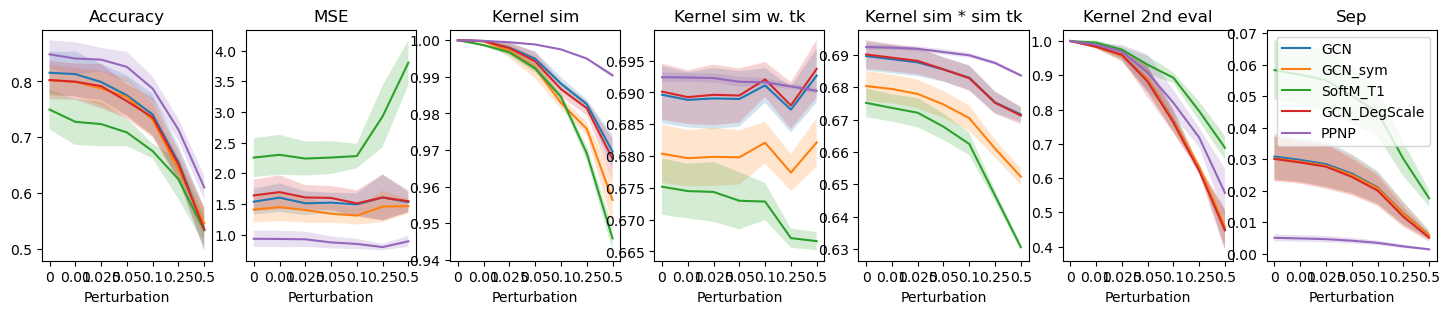

In [96]:
fig = plt.figure(figsize=(18,3))
for model_dict in model_dict_l:
    k_sim = []
    k_sim_tk = []
    k_eig_2 = []
    k_bd = []
    ntk = model_dict["label"]
    for s in range(len(ntk_random[ntk])):
        sim = []
        sim_tk = []
        eig = []
        bd = []
        tk = None
        for i in range(len(ntk_random[ntk][0])):
            kernel = ntk_random[ntk][s][i].get_ntk()
            if i == 0:
                tk = kernel
            sim.append(utils.kernel_alignment(tk.float(), kernel.float()))
            sim_tk.append(utils.kernel_alignment(true_kernel.float(), kernel.float()))
            bd.append(utils.class_separability(kernel.numpy()))

            eigval = torch.linalg.eigvalsh(kernel)
            eigval = torch.flip(eigval, dims=(0,))
            eig.append(eigval[1])
        k_sim.append(sim)
        k_sim_tk.append(sim_tk)
        k_eig_2.append(eig)
        k_bd.append(bd)
    # print(ntk , k_sim)
    k_sim = np.array(k_sim)
    k_sim_tk = np.array(k_sim_tk)
    k_eig_2 = np.array(k_eig_2)
    k_bd = np.array(k_bd)
    
    plt.subplot(171)
    acc = model_dict["label"]+'_acc'
    k_acc = np.array(ntk_random[acc])
    plt.plot(np.mean(k_acc, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_acc.shape[1]), np.mean(k_acc, axis=0)+np.std(k_acc, axis=0), np.mean(k_acc, axis=0)-np.std(k_acc, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Accuracy')

    plt.subplot(172)
    mse = model_dict["label"]+'_mse'
    k_mse = np.array(ntk_random[mse])
    plt.plot(np.mean(k_mse, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_mse.shape[1]), np.mean(k_mse, axis=0)+np.std(k_mse, axis=0), np.mean(k_mse, axis=0)-np.std(k_mse, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('MSE')

    plt.subplot(173)
    plt.plot(np.mean(k_sim, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_sim, axis=0)+np.std(k_sim, axis=0), np.mean(k_sim, axis=0)-np.std(k_sim, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim')

    plt.subplot(174)
    plt.plot(np.mean(k_sim_tk, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim_tk.shape[1]), np.mean(k_sim_tk, axis=0)+np.std(k_sim_tk, axis=0), np.mean(k_sim_tk, axis=0)-np.std(k_sim_tk, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim w. tk')

    plt.subplot(175)
    k_sim_sim_tk = k_sim * k_sim_tk
    plt.plot(np.mean(k_sim_sim_tk, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim_sim_tk.shape[1]), np.mean(k_sim_sim_tk, axis=0)+np.std(k_sim_sim_tk, axis=0), np.mean(k_sim_sim_tk, axis=0)-np.std(k_sim_sim_tk, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim * sim tk')

    plt.subplot(176)
    a = k_eig_2[:,0].reshape(-1,1) @ np.ones((1,k_sim.shape[1]))
    k_eig = k_eig_2/a
    plt.plot(np.mean(k_eig, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_eig, axis=0)+np.std(k_eig, axis=0), np.mean(k_eig, axis=0)-np.std(k_eig, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel 2nd eval')

    plt.subplot(177)
    # a = k_bd[:,0].reshape(-1,1) @ np.ones((1,k_sim.shape[1]))
    # k_bd = k_bd/a
    plt.plot(np.mean(k_bd, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_bd, axis=0)+np.std(k_bd, axis=0), np.mean(k_bd, axis=0)-np.std(k_bd, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Sep')
    
plt.legend()
        

In [87]:
model_dict_grad_l = [model_dict_gcn, model_dict_sym_gcn, model_dict_softmedoid, model_dict_ppnp] # model_dict_gcn_degree_scaling] #[model_dict_gcn, model_dict_sym_gcn, model_dict_softmedoid5] #, model_dict_gcn_tbn, model_dict_gcn_degree_scaling]

attack_grad_params = {
    "attack": "prbcd",
    "search_space_size": 50_000,
    "epochs": 100,
    "fine_tune_epochs": 0
}
# Attack
eps_grad_l = [0, 0.05, 0.10, 0.25]
ntk_grad = compute_ntk(model_dict_grad_l, eps_grad_l, attack_grad_params, true_kernel, seed, seed_l)


model  GCN
[1709.8026051701668, 119.07436487696434, 101.30526276581301, 98.05971347808894, 92.28223950084383]


100%|██████████| 100/100 [08:48<00:00,  5.28s/it]


[1680.5578737677472, 115.07425257755429, 98.24437985649409, 97.23949939201272, 89.76733519369934]


100%|██████████| 100/100 [08:42<00:00,  5.23s/it]


[1630.5343302094477, 107.0137581749746, 95.2566370774923, 89.40755968669306, 85.37624684722736]


100%|██████████| 100/100 [08:15<00:00,  4.96s/it]


[1536.8331141675844, 98.53352913683602, 93.60693831317386, 83.34854364793694, 80.34811527951557]
model  GCN_sym
[1700.6545153637448, 111.5170168213363, 96.40375197181736, 90.41542110573907, 87.52016805648721]


100%|██████████| 100/100 [08:55<00:00,  5.35s/it]


[1659.4989658703862, 106.06108375797395, 95.24862925354539, 89.15325171125183, 84.10838922147929]


100%|██████████| 100/100 [08:51<00:00,  5.32s/it]


[1606.6190955506388, 101.50400825361442, 92.89067673237102, 83.54719203050014, 80.62560261149015]


100%|██████████| 100/100 [08:46<00:00,  5.26s/it]


[1502.35856302495, 92.77424563389111, 86.19547213662855, 77.76806799355549, 72.48975349575772]
model  SoftM_T1
[1339.0536858617347, 229.46147328724672, 184.4129324372242, 164.18861343873823, 150.78838249477056]


100%|██████████| 100/100 [04:51<00:00,  2.92s/it]


[1345.5946099681778, 230.03243420409825, 181.3804499544305, 165.8535180292929, 147.7952931832036]


100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


[1338.0150861845896, 221.8430617215261, 185.19828859612227, 167.461710552511, 145.43350302261197]


100%|██████████| 100/100 [04:59<00:00,  2.99s/it]


[1346.9615797746546, 243.1777253160005, 175.0463559318588, 169.3763316808072, 137.87627776181787]
model  PPNP
[5474.21712559581, 76.53198944809931, 75.53945504891254, 67.18486609972653, 64.32683022122909]


100%|██████████| 100/100 [04:26<00:00,  2.66s/it]


[5471.287789131598, 72.73600418992723, 68.50868167852997, 63.5102414839818, 55.12343227593388]


100%|██████████| 100/100 [05:00<00:00,  3.00s/it]


[5445.529559448664, 68.6788097132968, 60.161082242804, 43.78213599008672, 40.029813566815946]


100%|██████████| 100/100 [04:54<00:00,  2.94s/it]


[5363.068573579973, 63.391093455926935, 48.64837824407017, 40.047040450786994, 31.802640466124025]


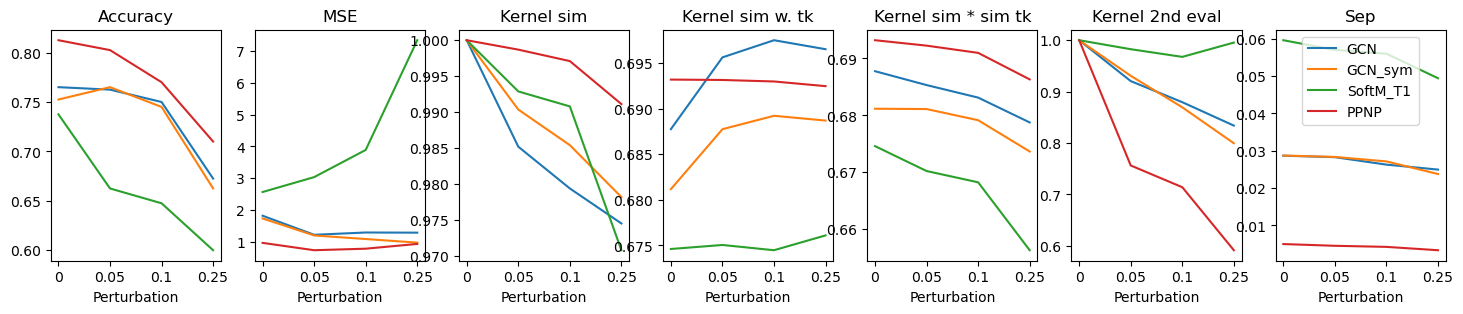

In [90]:
fig = plt.figure(figsize=(18,3))
for model_dict in model_dict_grad_l:
    k_sim = []
    k_sim_tk = []
    k_eig_2 = []
    k_bd = []
    ntk = model_dict["label"]
    for s in range(len(ntk_grad[ntk])):
        sim = []
        sim_tk = []
        eig = []
        bd = []
        tk = None
        for i in range(len(ntk_grad[ntk][0])):
            kernel = ntk_grad[ntk][s][i].get_ntk()
            if i == 0:
                tk = kernel
            sim.append(utils.kernel_alignment(tk.float(), kernel.float()))
            sim_tk.append(utils.kernel_alignment(true_kernel.float(), kernel.float()))
            bd.append(utils.class_separability(kernel.numpy()))

            eigval = torch.linalg.eigvalsh(kernel)
            eigval = torch.flip(eigval, dims=(0,))
            eig.append(eigval[1]/eigval[0])
        k_sim.append(sim)
        k_sim_tk.append(sim_tk)
        k_eig_2.append(eig)
        k_bd.append(bd)
    # print(ntk , k_sim)
    k_sim = np.array(k_sim)
    k_sim_tk = np.array(k_sim_tk)
    k_eig_2 = np.array(k_eig_2)
    k_bd = np.array(k_bd)
    
    plt.subplot(171)
    acc = model_dict["label"]+'_acc'
    k_acc = np.array(ntk_grad[acc])
    plt.plot(np.mean(k_acc, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_acc.shape[1]), np.mean(k_acc, axis=0)+np.std(k_acc, axis=0), np.mean(k_acc, axis=0)-np.std(k_acc, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Accuracy')

    plt.subplot(172)
    mse = model_dict["label"]+'_mse'
    k_mse = np.array(ntk_grad[mse])
    plt.plot(np.mean(k_mse, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_mse.shape[1]), np.mean(k_mse, axis=0)+np.std(k_mse, axis=0), np.mean(k_mse, axis=0)-np.std(k_mse, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('MSE')

    plt.subplot(173)
    plt.plot(np.mean(k_sim, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_sim, axis=0)+np.std(k_sim, axis=0), np.mean(k_sim, axis=0)-np.std(k_sim, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim')

    plt.subplot(174)
    plt.plot(np.mean(k_sim_tk, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim_tk.shape[1]), np.mean(k_sim_tk, axis=0)+np.std(k_sim_tk, axis=0), np.mean(k_sim_tk, axis=0)-np.std(k_sim_tk, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim w. tk')

    plt.subplot(175)
    k_sim_sim_tk = k_sim * k_sim_tk
    plt.plot(np.mean(k_sim_sim_tk, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim_sim_tk.shape[1]), np.mean(k_sim_sim_tk, axis=0)+np.std(k_sim_sim_tk, axis=0), np.mean(k_sim_sim_tk, axis=0)-np.std(k_sim_sim_tk, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim * sim tk')

    plt.subplot(176)
    a = k_eig_2[:,0].reshape(-1,1) @ np.ones((1,k_sim.shape[1]))
    k_eig = k_eig_2/a
    plt.plot(np.mean(k_eig, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_eig, axis=0)+np.std(k_eig, axis=0), np.mean(k_eig, axis=0)-np.std(k_eig, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel 2nd eval')

    plt.subplot(177)
    # a = k_bd[:,0].reshape(-1,1) @ np.ones((1,k_sim.shape[1]))
    # k_bd = k_bd/a
    plt.plot(np.mean(k_bd, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_bd, axis=0)+np.std(k_bd, axis=0), np.mean(k_bd, axis=0)-np.std(k_bd, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Sep')
    
plt.legend()
        

In [92]:
ntk_grad_2 = compute_ntk(model_dict_grad_l, eps_grad_l, attack_grad_params, true_kernel, seed, seed_l)


model  GCN
[1709.8026051701668, 119.07436487696434, 101.30526276581301, 98.05971347808894, 92.28223950084383]


100%|██████████| 100/100 [09:21<00:00,  5.61s/it]


[1680.5578737677472, 115.07425257755429, 98.24437985649409, 97.23949939201272, 89.76733519369934]


100%|██████████| 100/100 [08:54<00:00,  5.34s/it]


[1630.5343302094477, 107.0137581749746, 95.2566370774923, 89.40755968669306, 85.37624684722736]


100%|██████████| 100/100 [09:09<00:00,  5.50s/it]


[1536.8331141675844, 98.53352913683602, 93.60693831317386, 83.34854364793694, 80.34811527951557]
model  GCN_sym
[1700.6545153637448, 111.5170168213363, 96.40375197181736, 90.41542110573907, 87.52016805648721]


100%|██████████| 100/100 [09:39<00:00,  5.80s/it]


[1659.4989658703862, 106.06108375797395, 95.24862925354539, 89.15325171125183, 84.10838922147929]


100%|██████████| 100/100 [09:26<00:00,  5.66s/it]


[1606.6190955506388, 101.50400825361442, 92.89067673237102, 83.54719203050014, 80.62560261149015]


100%|██████████| 100/100 [09:27<00:00,  5.68s/it]


[1502.35856302495, 92.77424563389111, 86.19547213662855, 77.76806799355549, 72.48975349575772]
model  SoftM_T1
[1339.0536858617347, 229.46147328724672, 184.4129324372242, 164.18861343873823, 150.78838249477056]


100%|██████████| 100/100 [04:56<00:00,  2.97s/it]


[1345.5946099681778, 230.03243420409825, 181.3804499544305, 165.8535180292929, 147.7952931832036]


100%|██████████| 100/100 [04:25<00:00,  2.66s/it]


[1338.0150861845896, 221.8430617215261, 185.19828859612227, 167.461710552511, 145.43350302261197]


100%|██████████| 100/100 [04:51<00:00,  2.91s/it]


[1346.9615797746546, 243.1777253160005, 175.0463559318588, 169.3763316808072, 137.87627776181787]
model  PPNP
[5474.21712559581, 76.53198944809931, 75.53945504891254, 67.18486609972653, 64.32683022122909]


100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


[5471.287789131598, 72.73600418992723, 68.50868167852997, 63.5102414839818, 55.12343227593388]


100%|██████████| 100/100 [04:27<00:00,  2.68s/it]


[5445.529559448664, 68.6788097132968, 60.161082242804, 43.78213599008672, 40.029813566815946]


100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


[5363.068573579973, 63.391093455926935, 48.64837824407017, 40.047040450786994, 31.802640466124025]
model  GCN
[1639.6280183541255, 104.09048606966064, 93.18660995274995, 78.29668875980013, 62.65315568435113]


100%|██████████| 100/100 [08:21<00:00,  5.01s/it]


[1600.9565474929047, 101.62097534593164, 89.61384554227068, 76.6047837508178, 60.49654571180807]


100%|██████████| 100/100 [08:17<00:00,  4.97s/it]


[1561.639938721199, 88.02404502127197, 73.39347550403261, 62.94491637547857, 57.951349149869024]


100%|██████████| 100/100 [08:22<00:00,  5.02s/it]


[1447.3741787086046, 82.31196942273661, 71.92804881112323, 62.61671445834685, 50.53861613071459]
model  GCN_sym
[1610.011227479409, 99.7036202765992, 85.1310608729701, 73.85505749430695, 57.500580033062626]


100%|██████████| 100/100 [08:58<00:00,  5.39s/it]


[1572.2309248342685, 98.6352878506257, 82.14615363608259, 72.6723895629781, 54.24556921533528]


100%|██████████| 100/100 [08:56<00:00,  5.36s/it]


[1535.8364860783267, 98.28339793180942, 78.09615992650747, 71.07113201389191, 52.94808187916681]


100%|██████████| 100/100 [08:57<00:00,  5.38s/it]


[1406.5586763675924, 94.29796407569768, 70.53083630751476, 63.631279433351324, 45.16679421804124]
model  SoftM_T1
[1334.2034363842045, 216.65040688973443, 156.96560682747656, 152.91429523483362, 144.6483332167804]


100%|██████████| 100/100 [04:51<00:00,  2.92s/it]


[1328.7649035529798, 214.93373009879105, 157.15528329212916, 150.79477620666825, 145.0819391427142]


100%|██████████| 100/100 [05:39<00:00,  3.40s/it]


[1335.6221017780813, 218.8997037527687, 159.4751373867716, 149.94657314388814, 144.37913862000912]


100%|██████████| 100/100 [04:51<00:00,  2.92s/it]


[1329.1175036934428, 198.58858040615752, 154.72059973240417, 149.7222163732716, 145.4179792834144]
model  PPNP
[5499.108282542268, 79.10445248358684, 60.49737263350363, 47.940033402131434, 38.93351302766886]


100%|██████████| 100/100 [04:25<00:00,  2.65s/it]


[5505.214642993295, 78.3816637446717, 51.578082763294304, 44.4493673956935, 36.864761792692086]


100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


[5453.42472620416, 78.20378051344039, 44.15905500869699, 40.01367826306171, 33.73659601289815]


100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


[5338.524968795822, 76.8779580997267, 46.41239884309107, 40.062678641410685, 33.60754083052477]
model  GCN
[1791.0718657809198, 175.7705141849229, 110.86819084108006, 100.62430592248634, 89.10560912564031]


100%|██████████| 100/100 [08:19<00:00,  4.99s/it]


[1742.7596108637126, 168.04021558920385, 101.37256677975603, 96.43434671255218, 87.11447695112872]


100%|██████████| 100/100 [08:14<00:00,  4.95s/it]


[1707.6106516417658, 159.70980889484423, 102.18682758395977, 95.95374552529515, 84.45333728139641]


100%|██████████| 100/100 [09:29<00:00,  5.69s/it]


[1554.3777694784721, 135.12490960189768, 88.60616192249131, 72.71800213818693, 69.2141755540267]
model  GCN_sym
[1769.3010923295528, 161.66417950670137, 105.7341991121151, 97.59490600993415, 84.68202898775276]


100%|██████████| 100/100 [43:54<00:00, 26.35s/it]  


[1720.4267640257578, 152.11529685795153, 101.33289793196695, 93.05588757836401, 81.3365671973465]


100%|██████████| 100/100 [08:50<00:00,  5.30s/it]


[1655.964471395499, 144.22266890714576, 98.1724182205902, 84.42927045070566, 76.24512477474636]


100%|██████████| 100/100 [08:42<00:00,  5.23s/it]


[1487.5847816648607, 112.65287279828117, 70.7981917720764, 58.65426625440324, 49.409089276378815]
model  SoftM_T1
[1352.5180083824566, 272.33074109769245, 175.07043718776637, 165.99980803117117, 143.45325550664433]


100%|██████████| 100/100 [04:15<00:00,  2.56s/it]


[1345.255925175406, 262.54196145640026, 172.59029300375627, 163.61573468039757, 141.87825558314452]


100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


[1339.3847163716362, 262.9723876750693, 173.6688877753546, 157.65448550049385, 146.5945746441872]


100%|██████████| 100/100 [05:01<00:00,  3.02s/it]


[1358.918028337342, 244.07749108271847, 225.20710266859598, 167.51079556224124, 143.45835634928807]
model  PPNP
[5538.244031442037, 107.94672831624874, 86.83715753155938, 73.56394682951797, 67.26409685390665]


100%|██████████| 100/100 [04:18<00:00,  2.58s/it]


[5534.191837544005, 101.10404861318409, 85.78530180195636, 72.2974142639176, 65.03060034150148]


100%|██████████| 100/100 [04:17<00:00,  2.58s/it]


[5502.433103565222, 97.87363298942128, 80.60911689523132, 64.8806642148801, 62.87014102726208]


100%|██████████| 100/100 [04:17<00:00,  2.57s/it]


[5392.833346999398, 84.68558114449844, 76.53659682169274, 57.800167008937635, 47.758583770331455]
model  GCN
[1765.1723481753997, 151.93590118931496, 97.48594155641501, 88.84115093996392, 83.38763282983116]


100%|██████████| 100/100 [08:01<00:00,  4.81s/it]


[1702.8136877152292, 134.23984446014697, 91.33116321459238, 81.74446358164883, 76.9284409260324]


100%|██████████| 100/100 [08:00<00:00,  4.80s/it]


[1657.1742404184083, 126.86450399778069, 86.81912517394366, 78.67990281689337, 76.48597468150294]


100%|██████████| 100/100 [08:00<00:00,  4.80s/it]


[1526.126072122483, 115.55077913637727, 76.44046317555862, 72.2644412453228, 69.00902142308134]
model  GCN_sym
[1745.5617286570177, 143.88065107864838, 93.28254588267272, 84.52587975243647, 79.44612558855565]


100%|██████████| 100/100 [08:34<00:00,  5.14s/it]


[1687.8493181114047, 124.63191032527892, 88.46632686758329, 76.6818806304602, 75.00106894120003]


100%|██████████| 100/100 [08:35<00:00,  5.16s/it]


[1627.8406639002012, 120.61720780530699, 85.79085698854503, 72.86100431199665, 66.94858103366684]


100%|██████████| 100/100 [08:34<00:00,  5.14s/it]


[1520.1786169828263, 105.74115917239526, 76.8758296951346, 71.75324087545326, 68.15194211085823]
model  SoftM_T1
[1373.1111653727353, 252.94423330487064, 164.3640801999428, 154.55910556931133, 145.58694843733355]


100%|██████████| 100/100 [04:15<00:00,  2.56s/it]


[1370.3443266258032, 234.7321260361773, 172.38314421554693, 154.5587799484728, 150.0437718290469]


100%|██████████| 100/100 [05:01<00:00,  3.02s/it]


[1398.3902270068165, 339.12383358436335, 283.5968468925177, 175.8173929338878, 148.05303745984008]


100%|██████████| 100/100 [04:16<00:00,  2.56s/it]


[1350.6577044518776, 203.0793402441625, 159.93600407733925, 156.6000371701492, 132.43056274812807]
model  PPNP
[5465.373666384385, 102.25975630454923, 74.38481952563322, 65.50874263426147, 61.76480414322441]


100%|██████████| 100/100 [04:17<00:00,  2.57s/it]


[5426.801100306539, 81.49777445707971, 68.38909301548671, 60.80009520599474, 51.473020758231144]


100%|██████████| 100/100 [04:17<00:00,  2.58s/it]


[5396.070777013077, 76.635122497412, 59.9185648110001, 55.565022046353995, 52.34761787887073]


100%|██████████| 100/100 [04:17<00:00,  2.57s/it]


[5269.793852614101, 71.50913030551669, 54.58659865662201, 48.51055552741265, 43.7078083571936]


In [131]:
ntk_random_2 = compute_ntk(model_dict_l, eps_l, attack_params, true_kernel, seed, seed_l)


model  GCN
[1709.8026051701668, 119.07436487696434, 101.30526276581301, 98.05971347808894, 92.28223950084383]
[1702.5853089193417, 118.3185927005964, 100.84999034266683, 97.39250032546947, 91.6563689052004]
[1688.5056316854045, 114.75824810314937, 99.03089781319662, 96.89428890000734, 90.6425216456384]
[1665.6673804452043, 109.88240283491845, 98.83003703285597, 95.03772657810256, 88.70694947895349]
[1640.0364853726555, 105.55780683955825, 96.3537372059786, 92.74380114045832, 84.69641671486262]
[1509.4359949447428, 91.68445387735575, 88.2052042887847, 80.07139773268477, 74.64929661765005]
[1316.9304006929692, 85.66998107770493, 57.94392278677408, 50.23279453464931, 47.88127075376564]
model  GCN_sym
[1700.6545153637448, 111.5170168213363, 96.40375197181736, 90.41542110573907, 87.52016805648721]
[1690.935308993889, 110.63319501939347, 95.86023118906589, 90.04286469642244, 86.65909590644607]
[1674.6940485889245, 107.83058333481685, 94.59993703091452, 89.1070121574868, 85.9028335981274]
[16

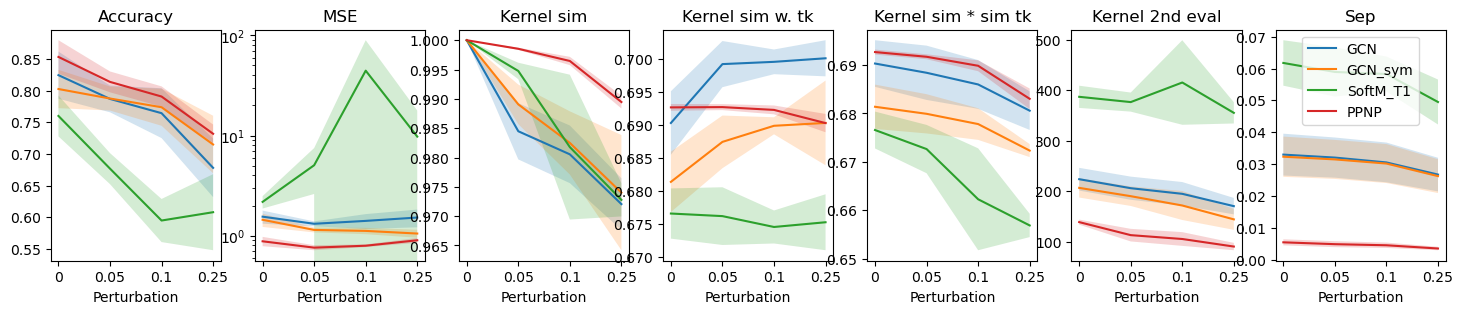

In [98]:
fig = plt.figure(figsize=(18,3))
for model_dict in model_dict_grad_l:
    k_sim = []
    k_sim_tk = []
    k_eig_2 = []
    k_bd = []
    ntk = model_dict["label"]
    for s in range(len(ntk_grad_2[ntk])):
        sim = []
        sim_tk = []
        eig = []
        bd = []
        tk = None
        for i in range(len(ntk_grad_2[ntk][0])):
            kernel = ntk_grad_2[ntk][s][i].get_ntk()
            if i == 0:
                tk = kernel
            sim.append(utils.kernel_alignment(tk.float(), kernel.float()))
            sim_tk.append(utils.kernel_alignment(true_kernel.float(), kernel.float()))
            bd.append(utils.class_separability(kernel.numpy()))

            eigval = torch.linalg.eigvalsh(kernel)
            eigval = torch.flip(eigval, dims=(0,))
            eig.append(eigval[1])
        k_sim.append(sim)
        k_sim_tk.append(sim_tk)
        k_eig_2.append(eig)
        k_bd.append(bd)
    # print(ntk , k_sim)
    k_sim = np.array(k_sim)
    k_sim_tk = np.array(k_sim_tk)
    k_eig_2 = np.array(k_eig_2)
    k_bd = np.array(k_bd)
    
    plt.subplot(171)
    acc = model_dict["label"]+'_acc'
    k_acc = np.array(ntk_grad_2[acc])
    plt.plot(np.mean(k_acc, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_acc.shape[1]), np.mean(k_acc, axis=0)+np.std(k_acc, axis=0), np.mean(k_acc, axis=0)-np.std(k_acc, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Accuracy')

    plt.subplot(172)
    mse = model_dict["label"]+'_mse'
    k_mse = np.array(ntk_grad_2[mse])
    plt.plot(np.mean(k_mse, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_mse.shape[1]), np.mean(k_mse, axis=0)+np.std(k_mse, axis=0), np.mean(k_mse, axis=0)-np.std(k_mse, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.yscale('log')
    plt.xlabel('Perturbation')
    plt.title('MSE')

    plt.subplot(173)
    plt.plot(np.mean(k_sim, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_sim, axis=0)+np.std(k_sim, axis=0), np.mean(k_sim, axis=0)-np.std(k_sim, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim')

    plt.subplot(174)
    plt.plot(np.mean(k_sim_tk, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim_tk.shape[1]), np.mean(k_sim_tk, axis=0)+np.std(k_sim_tk, axis=0), np.mean(k_sim_tk, axis=0)-np.std(k_sim_tk, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim w. tk')

    plt.subplot(175)
    k_sim_sim_tk = k_sim * k_sim_tk
    plt.plot(np.mean(k_sim_sim_tk, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim_sim_tk.shape[1]), np.mean(k_sim_sim_tk, axis=0)+np.std(k_sim_sim_tk, axis=0), np.mean(k_sim_sim_tk, axis=0)-np.std(k_sim_sim_tk, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim * sim tk')

    plt.subplot(176)
    a = k_eig_2[:,0].reshape(-1,1) @ np.ones((1,k_sim.shape[1]))
    k_eig = k_eig_2#/a
    plt.plot(np.mean(k_eig, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_eig, axis=0)+np.std(k_eig, axis=0), np.mean(k_eig, axis=0)-np.std(k_eig, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel 2nd eval')

    plt.subplot(177)
    # a = k_bd[:,0].reshape(-1,1) @ np.ones((1,k_sim.shape[1]))
    # k_bd = k_bd/a
    plt.plot(np.mean(k_bd, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_bd, axis=0)+np.std(k_bd, axis=0), np.mean(k_bd, axis=0)-np.std(k_bd, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Sep')
    
plt.legend()
        

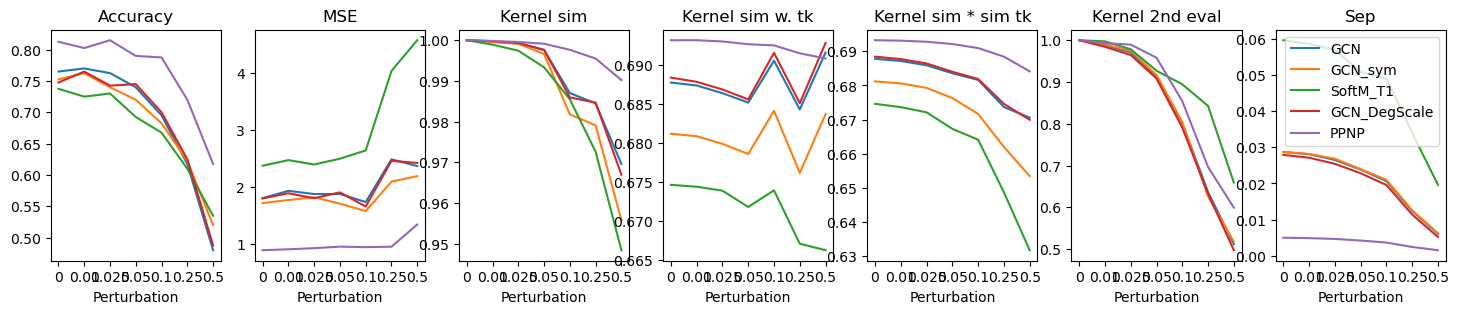

In [132]:
fig = plt.figure(figsize=(18,3))
for model_dict in model_dict_l:
    k_sim = []
    k_sim_tk = []
    k_eig_2 = []
    k_bd = []
    ntk = model_dict["label"]
    for s in range(len(ntk_random_2[ntk])):
        sim = []
        sim_tk = []
        eig = []
        bd = []
        tk = None
        for i in range(len(ntk_random_2[ntk][0])):
            kernel = ntk_random[ntk][s][i].get_ntk()
            if i == 0:
                tk = kernel
            sim.append(utils.kernel_alignment(tk.float(), kernel.float()))
            sim_tk.append(utils.kernel_alignment(true_kernel.float(), kernel.float()))
            bd.append(utils.class_separability(kernel.numpy()))

            eigval = torch.linalg.eigvalsh(kernel)
            eigval = torch.flip(eigval, dims=(0,))
            eig.append(eigval[1])
        k_sim.append(sim)
        k_sim_tk.append(sim_tk)
        k_eig_2.append(eig)
        k_bd.append(bd)
    # print(ntk , k_sim)
    k_sim = np.array(k_sim)
    k_sim_tk = np.array(k_sim_tk)
    k_eig_2 = np.array(k_eig_2)
    k_bd = np.array(k_bd)
    
    plt.subplot(171)
    acc = model_dict["label"]+'_acc'
    k_acc = np.array(ntk_random_2[acc])
    plt.plot(np.mean(k_acc, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_acc.shape[1]), np.mean(k_acc, axis=0)+np.std(k_acc, axis=0), np.mean(k_acc, axis=0)-np.std(k_acc, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Accuracy')

    plt.subplot(172)
    mse = model_dict["label"]+'_mse'
    k_mse = np.array(ntk_random_2[mse])
    plt.plot(np.mean(k_mse, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_mse.shape[1]), np.mean(k_mse, axis=0)+np.std(k_mse, axis=0), np.mean(k_mse, axis=0)-np.std(k_mse, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('MSE')

    plt.subplot(173)
    plt.plot(np.mean(k_sim, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_sim, axis=0)+np.std(k_sim, axis=0), np.mean(k_sim, axis=0)-np.std(k_sim, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim')

    plt.subplot(174)
    plt.plot(np.mean(k_sim_tk, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim_tk.shape[1]), np.mean(k_sim_tk, axis=0)+np.std(k_sim_tk, axis=0), np.mean(k_sim_tk, axis=0)-np.std(k_sim_tk, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim w. tk')

    plt.subplot(175)
    k_sim_sim_tk = k_sim * k_sim_tk
    plt.plot(np.mean(k_sim_sim_tk, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim_sim_tk.shape[1]), np.mean(k_sim_sim_tk, axis=0)+np.std(k_sim_sim_tk, axis=0), np.mean(k_sim_sim_tk, axis=0)-np.std(k_sim_sim_tk, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel sim * sim tk')

    plt.subplot(176)
    a = k_eig_2[:,0].reshape(-1,1) @ np.ones((1,k_sim.shape[1]))
    k_eig = k_eig_2/a
    plt.plot(np.mean(k_eig, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_eig, axis=0)+np.std(k_eig, axis=0), np.mean(k_eig, axis=0)-np.std(k_eig, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel 2nd eval')

    plt.subplot(177)
    # a = k_bd[:,0].reshape(-1,1) @ np.ones((1,k_sim.shape[1]))
    # k_bd = k_bd/a
    plt.plot(np.mean(k_bd, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_bd, axis=0)+np.std(k_bd, axis=0), np.mean(k_bd, axis=0)-np.std(k_bd, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Sep')
    
plt.legend()
        

eig val  tensor([1.0000, 0.0664, 0.0434, 0.0399, 0.0390], dtype=torch.float64)
eig val  tensor([1.0000, 0.0630, 0.0427, 0.0394, 0.0381], dtype=torch.float64)
eig val  tensor([1.0000, 0.0611, 0.0387, 0.0381, 0.0361], dtype=torch.float64)
eig val  tensor([1.0000, 0.0568, 0.0363, 0.0348, 0.0342], dtype=torch.float64)
eig val  tensor([1.0000, 0.0572, 0.0406, 0.0367, 0.0348], dtype=torch.float64)
eig val  tensor([1.0000, 0.0557, 0.0378, 0.0359, 0.0322], dtype=torch.float64)
eig val  tensor([1.0000, 0.0538, 0.0392, 0.0352, 0.0311], dtype=torch.float64)
eig val  tensor([1.0000, 0.0490, 0.0328, 0.0314, 0.0288], dtype=torch.float64)
eig val  tensor([1.0000, 0.0837, 0.0374, 0.0366, 0.0336], dtype=torch.float64)
eig val  tensor([1.0000, 0.0817, 0.0356, 0.0344, 0.0315], dtype=torch.float64)
eig val  tensor([1.0000, 0.0795, 0.0349, 0.0337, 0.0300], dtype=torch.float64)
eig val  tensor([1.0000, 0.0723, 0.0316, 0.0296, 0.0293], dtype=torch.float64)
eig val  tensor([1.0000, 0.0737, 0.0398, 0.0362, 0.0

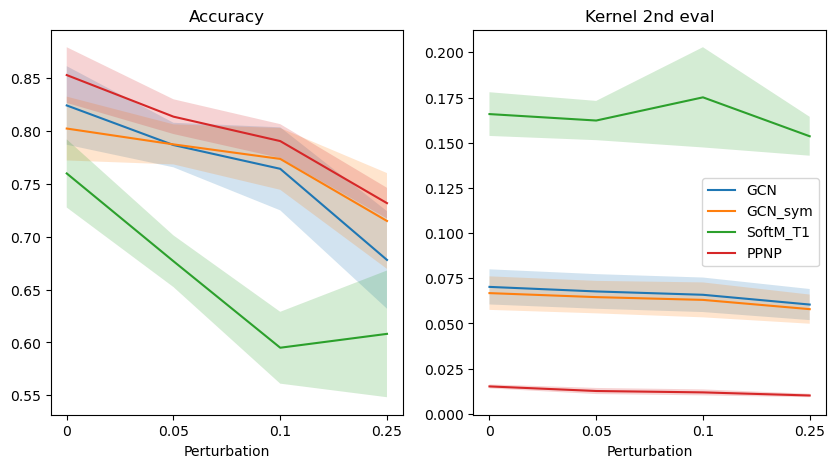

In [99]:
fig = plt.figure(figsize=(10,5))
for model_dict in model_dict_grad_l:
    k_eig_2 = []
    ntk = model_dict["label"]
    for s in range(len(ntk_grad_2[ntk])):
        eig = []
        for i in range(len(ntk_grad_2[ntk][0])):
            kernel = ntk_grad_2[ntk][s][i].get_ntk()
            kernel_norm = utils.sym_norm_kernel(kernel)
            eigval = torch.linalg.eigvalsh(kernel_norm)
            eigval = torch.flip(eigval, dims=(0,))
            print('eig val ', eigval[:5])
            eig.append(eigval[1])
        k_eig_2.append(eig)
    k_eig_2 = np.array(k_eig_2)
    
    plt.subplot(121)
    acc = model_dict["label"]+'_acc'
    k_acc = np.array(ntk_grad_2[acc])
    plt.plot(np.mean(k_acc, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_acc.shape[1]), np.mean(k_acc, axis=0)+np.std(k_acc, axis=0), np.mean(k_acc, axis=0)-np.std(k_acc, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Accuracy')

    plt.subplot(122)
    k_eig = k_eig_2
    plt.plot(np.mean(k_eig, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_sim.shape[1]), np.mean(k_eig, axis=0)+np.std(k_eig, axis=0), np.mean(k_eig, axis=0)-np.std(k_eig, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_sim.shape[1]), eps_grad_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel 2nd eval')
    
plt.legend()
        

eig val  tensor([1.0000, 0.0664, 0.0434, 0.0399, 0.0390], dtype=torch.float64)
eig val  tensor([1.0000, 0.0659, 0.0427, 0.0398, 0.0386], dtype=torch.float64)
eig val  tensor([1.0000, 0.0646, 0.0425, 0.0400, 0.0380], dtype=torch.float64)
eig val  tensor([1.0000, 0.0611, 0.0408, 0.0394, 0.0378], dtype=torch.float64)
eig val  tensor([1.0000, 0.0553, 0.0405, 0.0382, 0.0359], dtype=torch.float64)
eig val  tensor([1.0000, 0.0485, 0.0358, 0.0329, 0.0325], dtype=torch.float64)
eig val  tensor([1.0000, 0.0371, 0.0308, 0.0297, 0.0283], dtype=torch.float64)
eig val  tensor([1.0000, 0.0572, 0.0406, 0.0367, 0.0348], dtype=torch.float64)
eig val  tensor([1.0000, 0.0558, 0.0406, 0.0365, 0.0347], dtype=torch.float64)
eig val  tensor([1.0000, 0.0547, 0.0401, 0.0358, 0.0343], dtype=torch.float64)
eig val  tensor([1.0000, 0.0527, 0.0395, 0.0356, 0.0346], dtype=torch.float64)
eig val  tensor([1.0000, 0.0471, 0.0386, 0.0339, 0.0323], dtype=torch.float64)
eig val  tensor([1.0000, 0.0365, 0.0332, 0.0316, 0.0

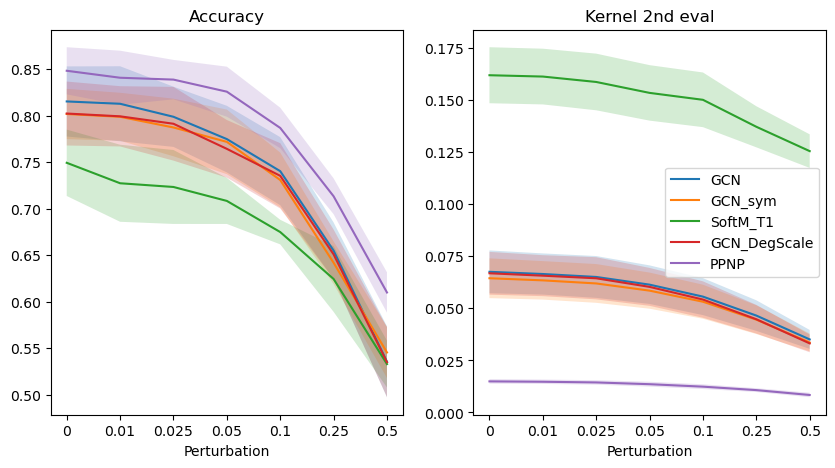

In [102]:
fig = plt.figure(figsize=(10,5))
for model_dict in model_dict_l:
    k_eig_2 = []
    ntk = model_dict["label"]
    for s in range(len(ntk_random[ntk])):
        eig = []
        for i in range(len(ntk_random[ntk][0])):
            kernel = ntk_random[ntk][s][i].get_ntk()
            kernel_norm = utils.sym_norm_kernel(kernel)
            eigval = torch.linalg.eigvalsh(kernel_norm)
            eigval = torch.flip(eigval, dims=(0,))
            print('eig val ', eigval[:5])
            eig.append(eigval[1])
        k_eig_2.append(eig)
    k_eig_2 = np.array(k_eig_2)
    
    plt.subplot(121)
    acc = model_dict["label"]+'_acc'
    k_acc = np.array(ntk_random[acc])
    plt.plot(np.mean(k_acc, axis=0), label=model_dict["label"])
    plt.fill_between(np.arange(0,k_acc.shape[1]), np.mean(k_acc, axis=0)+np.std(k_acc, axis=0), np.mean(k_acc, axis=0)-np.std(k_acc, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_acc.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Accuracy')

    plt.subplot(122)
    k_eig = k_eig_2
    plt.plot(np.mean(k_eig, axis=0), label=model_dict['label'])
    plt.fill_between(np.arange(0,k_acc.shape[1]), np.mean(k_eig, axis=0)+np.std(k_eig, axis=0), np.mean(k_eig, axis=0)-np.std(k_eig, axis=0), alpha=0.2)
    plt.xticks(np.arange(0,k_acc.shape[1]), eps_l)
    plt.xlabel('Perturbation')
    plt.title('Kernel 2nd eval')
    
plt.legend()
        

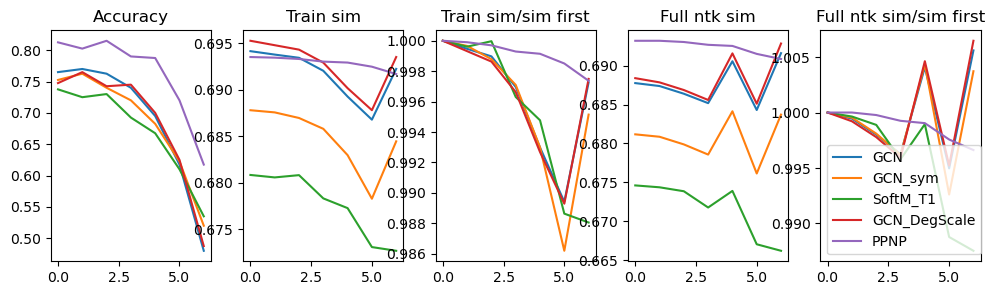

In [198]:
plt.figure(figsize=(12,3))
for model_dict in model_dict_l: 
    label = model_dict["label"]+'_train_sim'
    eig_2 = np.array(ntk_random[label][0])
    acc = model_dict["label"]+'_acc'
    # print(model_dict["label"], ' ', eig_2)
    plt.subplot(151)
    plt.plot(ntk_random[acc][0], label=model_dict["label"])
    plt.title('Accuracy')
    plt.subplot(152)
    plt.plot(eig_2, label=model_dict["label"])
    plt.title('Train sim')
    plt.subplot(153)
    plt.plot(eig_2/eig_2[0], label=model_dict["label"])
    plt.title('Train sim/sim first')

    ntk = model_dict["label"]
    eig_2_ntk = []
    for i in range(len(ntk_random[ntk][0])):
        kernel = ntk_random[ntk][0][i].get_ntk()
        # eigval = torch.linalg.eigvalsh(kernel)
        # eig = torch.flip(eigval, dims=(0,))
        eig = utils.kernel_alignment(kernel.float(), true_kernel.float())
        eig_2_ntk.append(eig)
    eig_2_ntk = np.array(eig_2_ntk)
    plt.subplot(154)
    plt.plot(eig_2_ntk, label=model_dict["label"])
    plt.title('Full ntk sim')
    plt.subplot(155)
    plt.plot(eig_2_ntk/eig_2_ntk[0], label=model_dict["label"])
    plt.title('Full ntk sim/sim first')
        
plt.legend()

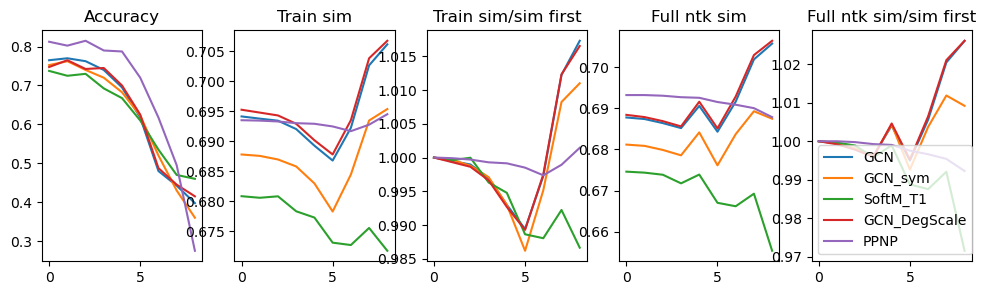

In [110]:
plt.figure(figsize=(12,3))
for model_dict in model_dict_l: 
    label = model_dict["label"]+'_train_sim'
    eig_2 = np.array(ntk_random[label][0])
    acc = model_dict["label"]+'_acc'
    # print(model_dict["label"], ' ', eig_2)
    plt.subplot(151)
    plt.plot(ntk_random[acc][0], label=model_dict["label"])
    plt.title('Accuracy')
    plt.subplot(152)
    plt.plot(eig_2, label=model_dict["label"])
    plt.title('Train sim')
    plt.subplot(153)
    plt.plot(eig_2/eig_2[0], label=model_dict["label"])
    plt.title('Train sim/sim first')

    ntk = model_dict["label"]
    eig_2_ntk = []
    for i in range(len(ntk_random[ntk][0])):
        kernel = ntk_random[ntk][0][i].get_ntk()
        # eigval = torch.linalg.eigvalsh(kernel)
        # eig = torch.flip(eigval, dims=(0,))
        eig = utils.kernel_alignment(kernel.float(), true_kernel.float())
        eig_2_ntk.append(eig)
    eig_2_ntk = np.array(eig_2_ntk)
    plt.subplot(154)
    plt.plot(eig_2_ntk, label=model_dict["label"])
    plt.title('Full ntk sim')
    plt.subplot(155)
    plt.plot(eig_2_ntk/eig_2_ntk[0], label=model_dict["label"])
    plt.title('Full ntk sim/sim first')
        
plt.legend()

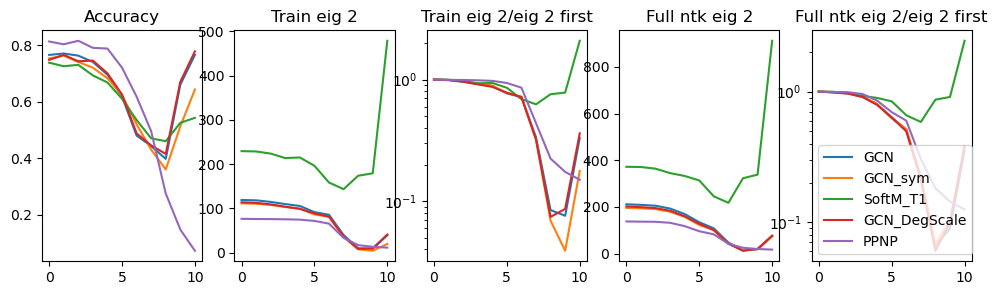

In [146]:
plt.figure(figsize=(12,3))
for model_dict in model_dict_l: 
    label = model_dict["label"]+'_train_eig'
    eig_2 = np.array(ntk_random[label][0])[:,1]
    acc = model_dict["label"]+'_acc'
    # print(model_dict["label"], ' ', eig_2)
    plt.subplot(151)
    plt.plot(ntk_random[acc][0], label=model_dict["label"])
    plt.title('Accuracy')
    plt.subplot(152)
    plt.plot(eig_2, label=model_dict["label"])
    plt.title('Train eig 2')
    plt.subplot(153)
    plt.plot(eig_2/eig_2[0], label=model_dict["label"])
    plt.yscale('log')
    plt.title('Train eig 2/eig 2 first')

    ntk = model_dict["label"]
    eig_2_ntk = []
    for i in range(len(ntk_random[ntk][0])):
        kernel = ntk_random[ntk][0][i].get_ntk()
        eigval = torch.linalg.eigvalsh(kernel)
        eig = torch.flip(eigval, dims=(0,))
        eig_2_ntk.append(eig[1])
    eig_2_ntk = np.array(eig_2_ntk)
    plt.subplot(154)
    plt.plot(eig_2_ntk, label=model_dict["label"])
    plt.title('Full ntk eig 2')
    plt.subplot(155)
    plt.plot(eig_2_ntk/eig_2_ntk[0], label=model_dict["label"])
    plt.title('Full ntk eig 2/eig 2 first')
    plt.yscale('log')
        
plt.legend()

## Check random/grad attack and ntk 

In [126]:
rng = np.random.Generator(np.random.PCG64(seed))
device_ = configure_hardware(device, seed)
data_dict["K"] = K
# Sample
X, A, y = get_graph(data_dict, seed=seed, sort=True)
X = torch.tensor(X, dtype=dtype, device=device_)
A = torch.tensor(A, dtype=dtype, device=device_)
y = torch.tensor(y, device=device_)

In [127]:
# Trn / Test Split
n_cls0 = sum(y == 0).cpu().item()
n = len(y)
idx_cls0 = rng.permutation(np.arange(n_cls0))
idx_cls1 = rng.permutation(np.arange(n_cls0, n))
n_trn = data_dict["n_per_class_trn"]
n_labeled = data_dict["n_per_class_labeled"]
idx_labeled = np.concatenate((idx_cls0[:n_labeled], idx_cls1[:n_labeled]))
idx_unlabeled = np.concatenate((idx_cls0[n_labeled:], idx_cls1[n_labeled:]))
idx_target = np.concatenate((idx_cls0[n_trn:], idx_cls1[n_trn:]))
attack = create_attack(idx_target, X, A, y, None, None, attack_params, seed)
n_pert = int(round(10 * count_edges_for_idx(A, idx_target)))
A_pert = attack.attack(n_pert)

tensor(3966., dtype=torch.float64) tensor(33752., dtype=torch.float64)


<Axes: >

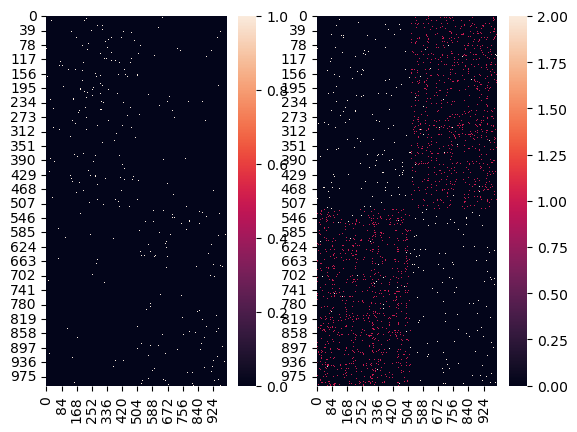

In [128]:
print(torch.sum(A), torch.sum(A_pert))
plt.subplot(121)
sns.heatmap(A)

plt.subplot(122)
# A_pert[(A_pert==2).nonzero(as_tuple=True)]=1
sns.heatmap(A_pert)

tensor(3966., dtype=torch.float64) tensor(33172., dtype=torch.float64)


<Axes: >

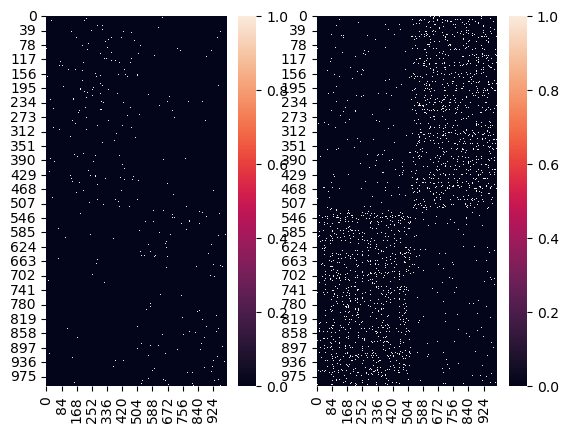

In [123]:
print(torch.sum(A), torch.sum(A_pert))
plt.subplot(121)
sns.heatmap(A)

plt.subplot(122)
A_pert[(A_pert==2).nonzero(as_tuple=True)]=1
sns.heatmap(A_pert)

tensor(25820., dtype=torch.float64)


<Axes: >

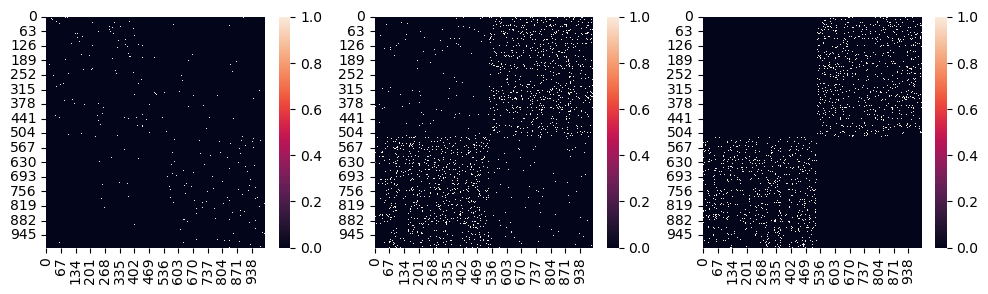

In [133]:
n_pert = int(round(10 * count_edges_for_idx(A, idx_target)))
A_pert = attack.attack(n_pert)
plt.figure(figsize=(12,3))
plt.subplot(131)
sns.heatmap(A)

plt.subplot(132)
A_pert[(A_pert==2).nonzero(as_tuple=True)]=1
sns.heatmap(A_pert)

plt.subplot(133)
A_diff = torch.abs(A-A_pert)
print(torch.sum(A_diff))
sns.heatmap(torch.abs(A-A_pert))


In [53]:
def process_kernel_2(k, p1=90, p2=10):
    g = [k > np.percentile(k,p1)][0]
    gg = [k < np.percentile(k,p2)][0]
    k[g] = np.mean(k)+ np.std(k) #(np.std(k)*k[g])
    k[gg] = np.mean(k)-np.std(k)
    return k

def process_kernel(k):
    g = [k > 2*np.mean(k)][0]
    kchanged = np.copy(k)
    kchanged[g] = 2*np.mean(k)+np.std(k)
    return kchanged

def get_accuracy(nt_kernel, idx_labeled, idx_unlabeled, y):
    krr = KernelRidge(alpha=1e-8, kernel='precomputed')
    ntk_labeled = nt_kernel[idx_labeled,:][:,idx_labeled]
    # ntk_labeled += 1e-8
    ntk_unlabeled = nt_kernel[idx_unlabeled,:][:,idx_labeled]
    krr.fit(ntk_labeled, y[idx_labeled]*2-1)
    y_pred_krr = krr.predict(ntk_unlabeled)
    # print(y_pred_krr)
    # acc_krr = utils.accuracy(torch.Tensor(y_pred_krr), y[idx_target]).cpu().item()
    y_pred = torch.tensor((y_pred_krr > 0).astype(float)).to(dtype=torch.long)
    # print(y_pred)
    # print(y[idx_target])
    acc_krr_1 = (y_pred == y[idx_target]).sum() / len(y[idx_target])
    # y_true = y[idx_target]-(y[idx_target]*2-1)
    # acc_krr_2 = (y_pred == y_true).sum() / len(y[idx_target]) 
    # print(acc_krr_1, acc_krr_2)
    return acc_krr_1 #if acc_krr_1 > acc_krr_2 else acc_krr_2

In [184]:
ntk = NTK(model_dict_gcn, X, A)
kernel = ntk.get_ntk()
print('GCN acc A ', get_accuracy(kernel, idx_labeled, idx_unlabeled, y))

tensor(0.8300) tensor(0.1700)
GCN acc A  tensor(0.8300)


GCN acc A  tensor(0.8075)
GCN acc Apert  tensor(0.7275)
kernel sim  tensor([0.9449], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6869], dtype=torch.float64)
kernel2 sim with tk  tensor([0.7723], dtype=torch.float64)
Diag zero 
kernel sim  tensor([0.9449], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6859], dtype=torch.float64)
kernel2 sim with tk  tensor([0.7712], dtype=torch.float64)
only train
kernel sim  tensor([0.9462], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6857], dtype=torch.float64)
kernel2 sim with tk  tensor([0.7615], dtype=torch.float64)


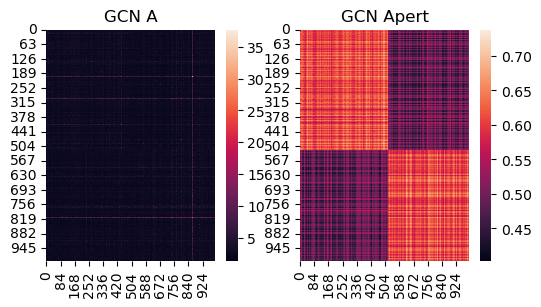

In [54]:
plt.figure(figsize=(6,3))
plt.subplot(121)
ntk = NTK(model_dict_gcn, X, A)
kernel = ntk.get_ntk()
print('GCN acc A ', get_accuracy(kernel, idx_labeled, idx_unlabeled, y))
sns.heatmap(diag_smoother((kernel).numpy()))
plt.title('GCN A')

plt.subplot(122)
ntk = NTK(model_dict_gcn, X, A_pert)
kernel2 = ntk.get_ntk()
print('GCN acc Apert ', get_accuracy(kernel2, idx_labeled, idx_unlabeled, y))
sns.heatmap(diag_smoother(kernel2))
plt.title('GCN Apert')
print('kernel sim ', utils.kernel_cosine_sim(kernel, kernel2))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel, true_kernel))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel, kernel2))
print('Diag zero ')
kernel = kernel - np.diag(np.diagonal(kernel))
kernel2 = kernel2 - np.diag(np.diagonal(kernel2))
print('kernel sim ', utils.kernel_cosine_sim(kernel, kernel2))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel, true_kernel))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel, kernel2))
print('only train')
kernel_labeled = kernel[idx_labeled,:][:,idx_labeled]
kernel2_labeled = kernel2[idx_labeled,:][:,idx_labeled]
print('kernel sim ', utils.kernel_cosine_sim(kernel_labeled, kernel2_labeled))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel_labeled, true_kernel[idx_labeled,:][:,idx_labeled]))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel[idx_labeled,:][:,idx_labeled], kernel2_labeled))



PPNP acc A  tensor(0.8375)
PPNP acc Apert  tensor(0.9325)
kernel sim  tensor([0.9457], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6921], dtype=torch.float64)
kernel2 sim with tk  tensor([0.6820], dtype=torch.float64)
kernel sim  tensor([0.9457], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6911], dtype=torch.float64)
kernel2 sim with tk  tensor([0.6810], dtype=torch.float64)
only train
kernel sim  tensor([0.9758], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6897], dtype=torch.float64)
kernel2 sim with tk  tensor([0.7032], dtype=torch.float64)


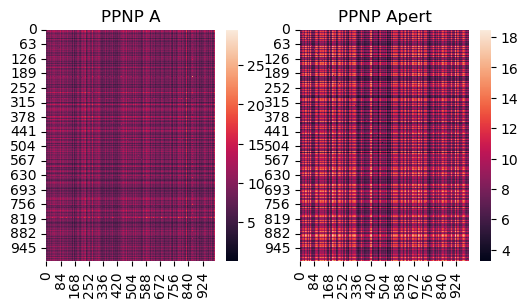

In [51]:
plt.figure(figsize=(6,3))
plt.subplot(121)
ntk = NTK(model_dict_ppnp, X, A)
kernel = ntk.get_ntk()
print('PPNP acc A ', get_accuracy(kernel, idx_labeled, idx_unlabeled, y))
sns.heatmap(diag_smoother(kernel))
plt.title('PPNP A')

plt.subplot(122)
ntk = NTK(model_dict_ppnp, X, A_pert)
kernel2 = ntk.get_ntk()
print('PPNP acc Apert ', get_accuracy(kernel2, idx_labeled, idx_unlabeled, y))
sns.heatmap(diag_smoother(kernel2))
plt.title('PPNP Apert')
print('kernel sim ', utils.kernel_cosine_sim(kernel, kernel2))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel, true_kernel))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel, kernel2))
kernel = kernel - np.diag(np.diagonal(kernel))
kernel2 = kernel2 - np.diag(np.diagonal(kernel2))
print('kernel sim ', utils.kernel_cosine_sim(kernel, kernel2))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel, true_kernel))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel, kernel2))
print('only train')
kernel_labeled = kernel[idx_labeled,:][:,idx_labeled]
kernel2_labeled = kernel2[idx_labeled,:][:,idx_labeled]
print('kernel sim ', utils.kernel_cosine_sim(kernel_labeled, kernel2_labeled))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel_labeled, true_kernel[idx_labeled,:][:,idx_labeled]))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel[idx_labeled,:][:,idx_labeled], kernel2_labeled))



PPNP acc A  tensor(0.7550)
PPNP acc Apert  tensor(0.5200)
kernel sim  tensor([0.7835], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6735], dtype=torch.float64)
kernel2 sim with tk  tensor([0.6213], dtype=torch.float64)
kernel sim  tensor([0.7835], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6725], dtype=torch.float64)
kernel2 sim with tk  tensor([0.6204], dtype=torch.float64)
only train
kernel sim  tensor([0.8063], dtype=torch.float64)
kernel1 sim with tk  tensor([0.6699], dtype=torch.float64)
kernel2 sim with tk  tensor([0.6536], dtype=torch.float64)


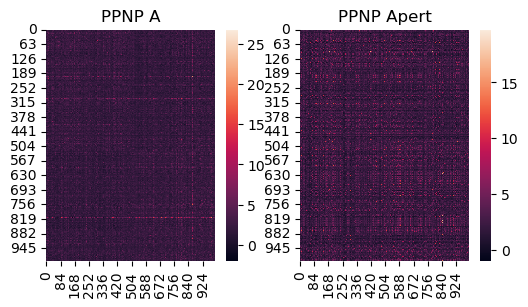

In [52]:
plt.figure(figsize=(6,3))
plt.subplot(121)
ntk = NTK(model_dict_softmedoid, X, A)
kernel = ntk.get_ntk()
print('PPNP acc A ', get_accuracy(kernel, idx_labeled, idx_unlabeled, y))
sns.heatmap(diag_smoother(kernel))
plt.title('PPNP A')

plt.subplot(122)
ntk = NTK(model_dict_softmedoid, X, A_pert)
kernel2 = ntk.get_ntk()
print('PPNP acc Apert ', get_accuracy(kernel2, idx_labeled, idx_unlabeled, y))
sns.heatmap(diag_smoother(kernel2))
plt.title('PPNP Apert')
print('kernel sim ', utils.kernel_cosine_sim(kernel, kernel2))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel, true_kernel))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel, kernel2))
kernel = kernel - np.diag(np.diagonal(kernel))
kernel2 = kernel2 - np.diag(np.diagonal(kernel2))
print('kernel sim ', utils.kernel_cosine_sim(kernel, kernel2))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel, true_kernel))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel, kernel2))
print('only train')
kernel_labeled = kernel[idx_labeled,:][:,idx_labeled]
kernel2_labeled = kernel2[idx_labeled,:][:,idx_labeled]
print('kernel sim ', utils.kernel_cosine_sim(kernel_labeled, kernel2_labeled))
print('kernel1 sim with tk ', utils.kernel_cosine_sim(kernel_labeled, true_kernel[idx_labeled,:][:,idx_labeled]))
print('kernel2 sim with tk ', utils.kernel_cosine_sim(true_kernel[idx_labeled,:][:,idx_labeled], kernel2_labeled))



tensor([0.9492], dtype=torch.float64)


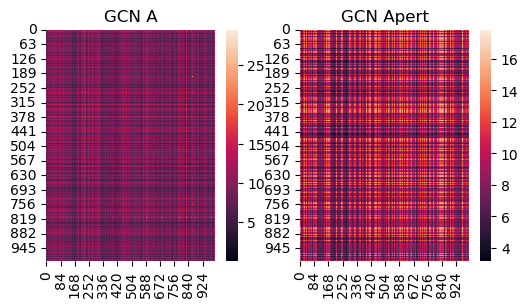

In [148]:
plt.figure(figsize=(6,3))
plt.subplot(121)
ntk = NTK(model_dict_appnp, X, A)
kernel = ntk.get_ntk()
sns.heatmap(diag_smoother(kernel))
plt.title('GCN A')

plt.subplot(122)
ntk = NTK(model_dict_appnp, X, A_pert)
kernel2 = ntk.get_ntk()
sns.heatmap(diag_smoother(kernel2))
plt.title('GCN Apert')
print(utils.kernel_cosine_sim(kernel, kernel2))

<Axes: >

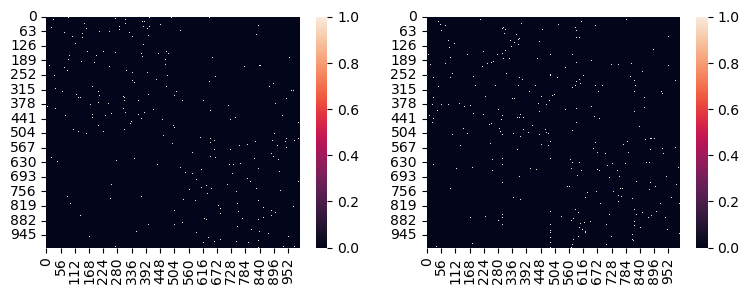

In [85]:
plt.figure(figsize=(9,3))
plt.subplot(121)
sns.heatmap(A)

plt.subplot(122)
A_pert = A_pert.to_dense()
A_pert[(A_pert==2).nonzero(as_tuple=True)]=1
sns.heatmap(A_pert)

In [44]:
#diag smoother
def diag_smoother(adj):
    for i in range(adj.shape[0]):
        if i==0:
            adj[i,i] = adj[i,i+1]
        else:
            adj[i,i] = adj[i,i-1]
    return adj

K1  tensor(1156281.1250) tensor(5875645.) tensor(0.6746) tensor(0.6764)
K2  tensor(1011648.8125) tensor(4765341.5000) tensor(0.6554) tensor(0.6556)


Text(0.5, 1.0, 'True @ k2.T')

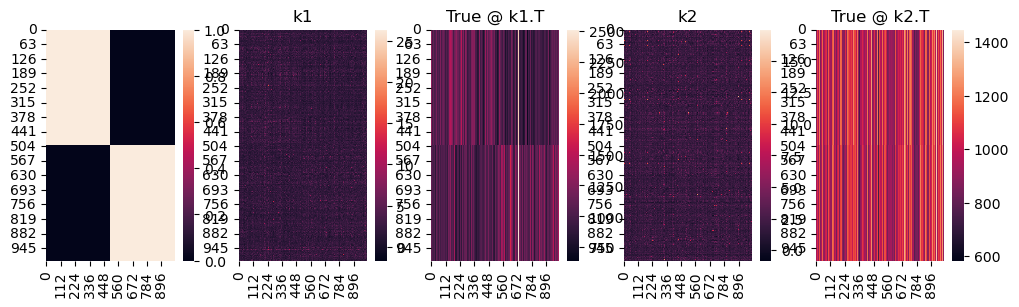

In [96]:
gcn_k1 = ntk_random["SoftM_T1"][0][0].get_ntk().float()
gcn_k2 = ntk_random["SoftM_T1"][0][8].get_ntk().float()
print("K1 " , torch.trace(true_kernel.float() @ gcn_k1.T.float()), torch.trace(gcn_k1.float() @ gcn_k1.T.float()), utils.kernel_alignment(true_kernel, gcn_k1), utils.kernel_alignment(true_kernel, diag_smoother(gcn_k1)))
print("K2 " , torch.trace(true_kernel.float() @ gcn_k2.T.float()), torch.trace(gcn_k2.float() @ gcn_k2.T.float()), utils.kernel_alignment(true_kernel, gcn_k2), utils.kernel_alignment(true_kernel, diag_smoother(gcn_k2)))
                                                       
plt.figure(figsize=(12,3))
plt.subplot(151)
sns.heatmap(true_kernel)

plt.subplot(152)
sns.heatmap(diag_smoother(gcn_k1))
plt.title('k1')

plt.subplot(153)
sns.heatmap(true_kernel @ gcn_k1.T)
plt.title('True @ k1.T')

plt.subplot(154)
sns.heatmap(diag_smoother(gcn_k2))
plt.title('k2')

plt.subplot(155)
sns.heatmap(true_kernel @ gcn_k2.T)
plt.title('True @ k2.T')


K1  tensor(1425858.8750) tensor(8596115.) tensor(0.6878) tensor(0.6899)
K2  tensor(404540.5625) tensor(634183.8750) tensor(0.7184) tensor(0.7184)


Text(0.5, 1.0, 'True @ k2.T')

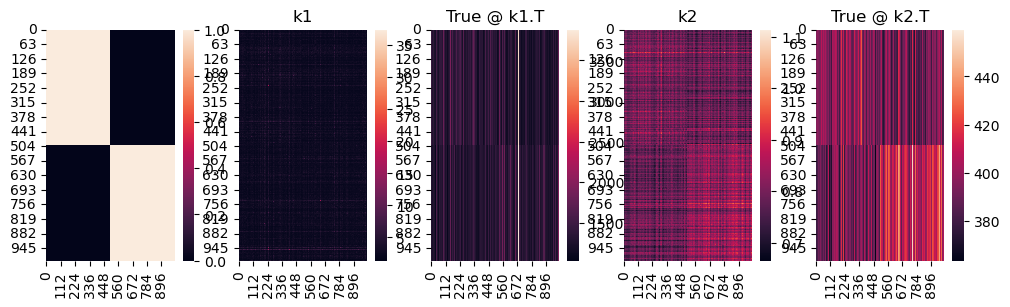

In [129]:
gcn_k1 = ntk_random["GCN"][0][0].get_ntk().float()
gcn_k2 = ntk_random["GCN"][0][9].get_ntk().float()
print("K1 " , torch.trace(true_kernel.float() @ gcn_k1.T.float()), torch.trace(gcn_k1.float() @ gcn_k1.T.float()), utils.kernel_alignment(true_kernel, gcn_k1), utils.kernel_alignment(true_kernel, diag_smoother(gcn_k1)))
print("K2 " , torch.trace(true_kernel.float() @ gcn_k2.T.float()), torch.trace(gcn_k2.float() @ gcn_k2.T.float()), utils.kernel_alignment(true_kernel, gcn_k2), utils.kernel_alignment(true_kernel, diag_smoother(gcn_k2)))

plt.figure(figsize=(12,3))
plt.subplot(151)
sns.heatmap(true_kernel)

plt.subplot(152)
sns.heatmap(diag_smoother(gcn_k1))
plt.title('k1')

plt.subplot(153)
sns.heatmap(true_kernel @ gcn_k1.T)
plt.title('True @ k1.T')

plt.subplot(154)
sns.heatmap(diag_smoother(gcn_k2))
plt.title('k2')

plt.subplot(155)
sns.heatmap(true_kernel @ gcn_k2.T)
plt.title('True @ k2.T')


## Block diff, MMD, Wasserstein

In [ ]:
def get_results(ntk_dict, model_dict_l, only_train=False, center_kernel=False, norm_kernel=False, zero_diag=False, norm_first=False, sym_norm=False):
    result_dict = dict()
    for model_dict in model_dict_l: 
        acc = ntk_dict[model_dict["label"]+"_acc"]
        block_diff = []
        # mmd = []
        # w2 = []
        eig = []
        # eig_r = []

        for s in seed_l:
            block_diff_s = []
            # mmd_s = []
            # w2_s = []
            eig_s = []
            # eig_r_s = []
            for i in range(len(ntk_dict[model_dict["label"]][s])):
                kernel = ntk_dict[model_dict["label"]][s][i].get_ntk().numpy()
                eigval = np.linalg.eigvalsh(kernel)
                eig_s.append(eigval[::-1][1]/eigval[::-1][0])
                # eig_r_s.append(eigval[::-1][0]/eigval[::-1][1])
                # if only_train:
                #     kernel = kernel[idx_labeled,:][:,idx_labeled]
                if zero_diag:
                    kernel = kernel - np.diag(np.diagonal(kernel))
                if norm_first:
                    kernel = kernel/np.linalg.norm(kernel)
                if sym_norm:
                    # kernel -= np.mean(kernel)
                    D_inv = np.diag(np.power(np.sum(kernel, axis=1), - 0.5))
                    kernel = D_inv @ kernel @ D_inv
                    kernel -= np.mean(kernel)
                block_diff_s.append(utils.block_diff(kernel, center_kernel, norm_kernel))
                # mmd_s.append(utils.kernel_mmd(kernel, center_kernel, norm_kernel))
                # w2_s.append(utils.kernel_w2(kernel, center_kernel, norm_kernel))
        
            block_diff.append(block_diff_s)
            # mmd.append(mmd_s)
            # w2.append(w2_s)
            eig.append(eig_s)

        
        result_dict[model_dict["label"]] = {
                                            "acc_mean": np.mean(np.array(acc), axis=0),
                                            "acc_std": np.std(np.array(acc), axis=0),
                                            "block_diff_mean": np.mean(np.array(block_diff), axis=0),
                                            "block_diff_std": np.std(np.array(block_diff), axis=0),
                                            # "mmd_mean": np.mean(np.array(mmd), axis=0),
                                            # "mmd_std": np.std(np.array(mmd), axis=0),
                                            # "w2_mean": np.mean(np.array(w2), axis=0),
                                            # "w2_std": np.std(np.array(w2), axis=0),
                                            "eig_mean": np.mean(np.array(eig), axis=0),
                                            "eig_std": np.std(np.array(eig), axis=0),
                                            # "eig_r_mean": np.mean(np.array(eig_r), axis=0),
                                            # "eig_r_std": np.std(np.array(eig_r), axis=0),
                                            }
    return result_dict
    

In [ ]:
def plot_acc_measure(result_dict):
    plt.figure(figsize=(12,4))
    x = np.arange(len(eps_l))
    plt.subplot(151)
    for model_dict in model_dict_l: 
        # plt.plot(result_dict[model_dict["label"]]["acc_mean"], label=model_dict["label"])
        plt.errorbar(x,result_dict[model_dict["label"]]["acc_mean"], yerr=result_dict[model_dict["label"]]["acc_std"], label=model_dict["label"], alpha=0.5)
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(152)
    for model_dict in model_dict_l: 
        # plt.plot(result_dict[model_dict["label"]]["block_diff_mean"], label=model_dict["label"])
        plt.errorbar(x,result_dict[model_dict["label"]]["block_diff_mean"], yerr=result_dict[model_dict["label"]]["block_diff_std"], label=model_dict["label"], alpha=0.5)
    # plt.legend()
    plt.title("Block diff")

    plt.subplot(153)
    for model_dict in model_dict_l: 
        # plt.plot(result_dict[model_dict["label"]]["mmd_mean"], label=model_dict["label"])
        plt.errorbar(x,result_dict[model_dict["label"]]["mmd_mean"], yerr=result_dict[model_dict["label"]]["mmd_std"], label=model_dict["label"], alpha=0.5)
    # plt.legend()
    plt.title("MMD")

    plt.subplot(154)
    for model_dict in model_dict_l: 
        # plt.plot(result_dict[model_dict["label"]]["w2_mean"], label=model_dict["label"])
        plt.errorbar(x,result_dict[model_dict["label"]]["w2_mean"], yerr=result_dict[model_dict["label"]]["w2_std"], label=model_dict["label"],alpha=0.5)
    # plt.legend()
    plt.title("W2")

    plt.subplot(155)
    for model_dict in model_dict_l: 
        # plt.plot(result_dict[model_dict["label"]]["w2_mean"], label=model_dict["label"])
        plt.errorbar(x,result_dict[model_dict["label"]]["eig_mean"], yerr=result_dict[model_dict["label"]]["eig_std"], label=model_dict["label"],alpha=0.5)
    # plt.legend()
    plt.title("Eigval")

    plt.show()


In [176]:
for model_dict in model_dict_l: 
    print(model_dict["label"])
    print(k[model_dict["label"]]["eig_mean"])
    print(1/k[model_dict["label"]]["eig_mean"])

GCN
[0.05542096 0.05492221 0.05467821 0.05306267 0.04805458 0.04249283
 0.0336311  0.02062917 0.00991885]
[ 18.04371644  18.20757107  18.28882236  18.84563959  20.80967112
  23.53338395  29.73438329  48.47504299 100.81811806]
GCN_sym
[0.05238909 0.05199086 0.05179409 0.05024578 0.04533982 0.04060883
 0.03233142 0.01808045 0.00880913]
[ 19.0879437   19.23414985  19.30722279  19.90216741  22.05566847
  24.62518373  30.92966805  55.30835729 113.5185814 ]
SoftM_T5
[0.05541547 0.05491729 0.0546728  0.05305822 0.04805237 0.04249279
 0.03362789 0.0206382  0.00992249]
[ 18.04550149  18.20919991  18.2906307   18.84722098  20.81062931
  23.5334063   29.73722534  48.45383786 100.78113738]
PPNP
[0.01604003 0.01594618 0.01577203 0.01524898 0.01377883 0.01194211
 0.00900521 0.00459695 0.00301829]
[ 62.34402612  62.71094581  63.40339129  65.57815416  72.57508111
  83.73730374 111.04687497 217.53569265 331.31343454]


In [190]:
print(k['GCN']['acc_mean'])
print(k['GCN_sym']['acc_mean'])
print(k['SoftM_T5']['acc_mean'])

[0.78916667 0.78416667 0.79083333 0.78083334 0.76666667 0.72666667
 0.6475     0.52916668 0.3925    ]
[0.77833333 0.77166667 0.7675     0.76583334 0.75166667 0.71416668
 0.63583334 0.52666666 0.37833333]
[0.78916667 0.78500001 0.79166667 0.78083334 0.76666667 0.72666667
 0.64916666 0.52916668 0.3925    ]


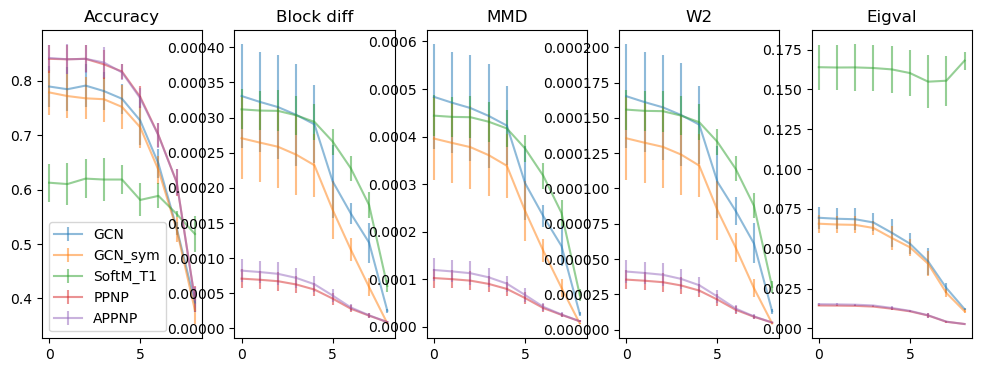

In [ ]:
# new ntk - relu gcn, random attack  with ppnp
# csbm with sparse param
random_gcn_ppnp_ntk_sparse_seed3 = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=True, norm_kernel=True)
plot_acc_measure(k)

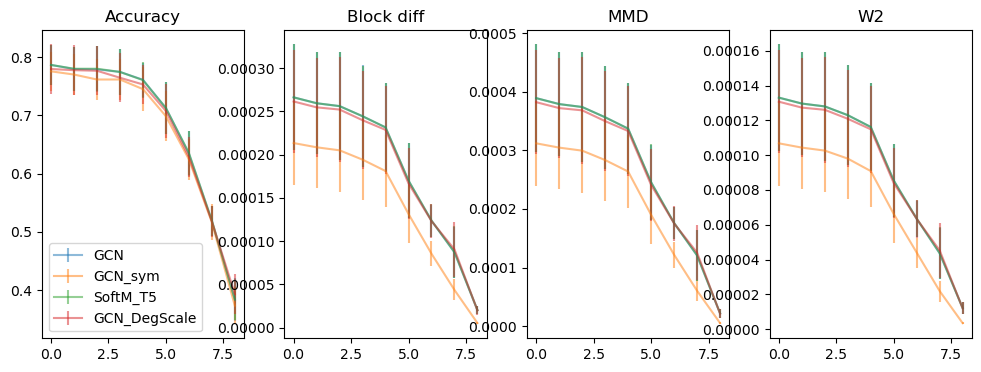

In [147]:
# new ntk - relu gcn, random attack 
# csbm with sparse param
random_relu_gcn_ntk_sparse_seed5 = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=True, norm_kernel=True)
plot_acc_measure(k)

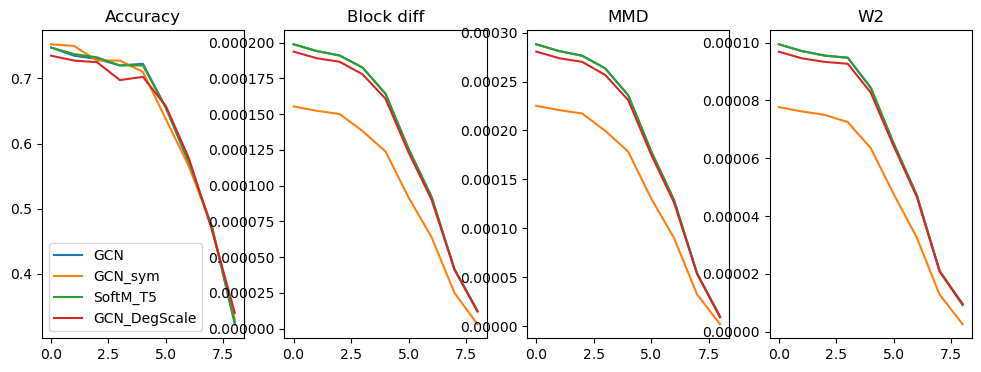

In [89]:
# new ntk - relu gcn, random attack 
# csbm with sparse param
random_relu_gcn_ntk_sparse = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=True, norm_kernel=True)
plot_acc_measure(k)

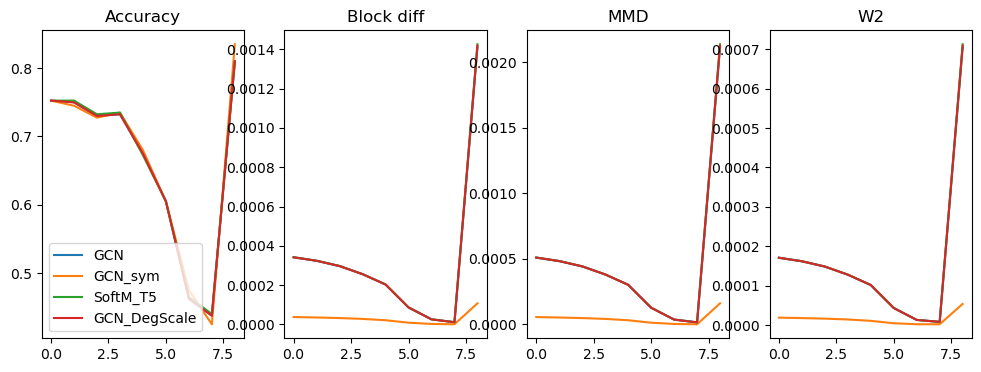

In [81]:
# new ntk - relu gcn, random attack
# p =0.05, q=0.03
random_relu_gcn_ntk_dense_2 = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=True, norm_kernel=True)
plot_acc_measure(k)

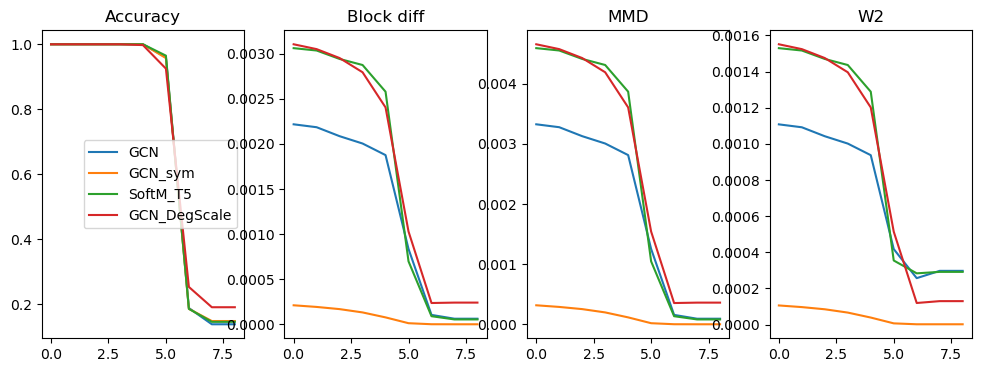

In [72]:
# new ntk - relu gcn, random attack
# p =0.6, q=0.4
random_relu_gcn_ntk_dense = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=True, norm_kernel=True)
plot_acc_measure(k)

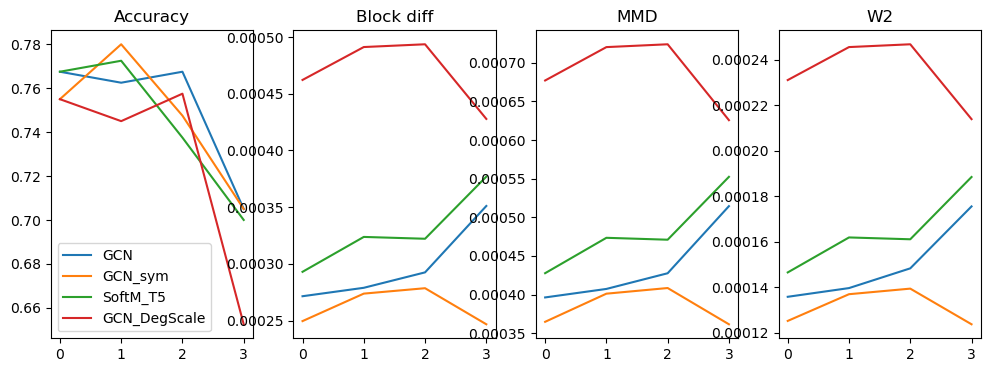

In [25]:
# new ntk - relu gcn, prbcd attack
prbcd_relu_gcn_ntk = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=False, norm_first=True)
plot_acc_measure(k)

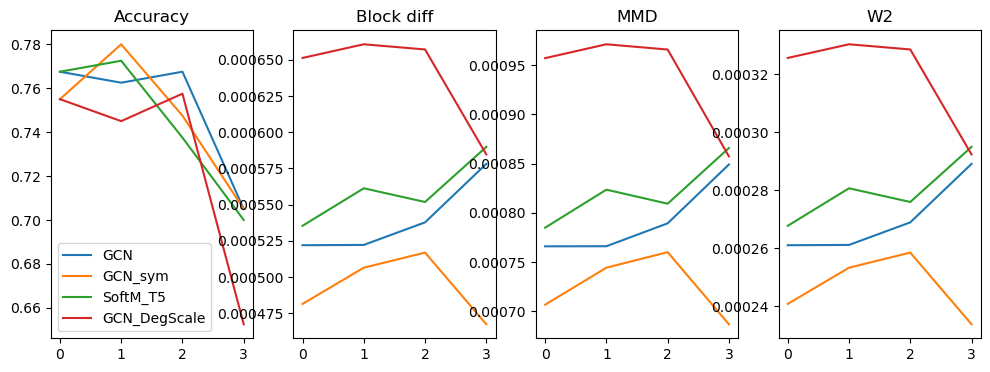

In [21]:
# new ntk - relu gcn, prbcd attack
prbcd_relu_gcn_ntk = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=False, norm_kernel=True, sym_norm=True)
plot_acc_measure(k)

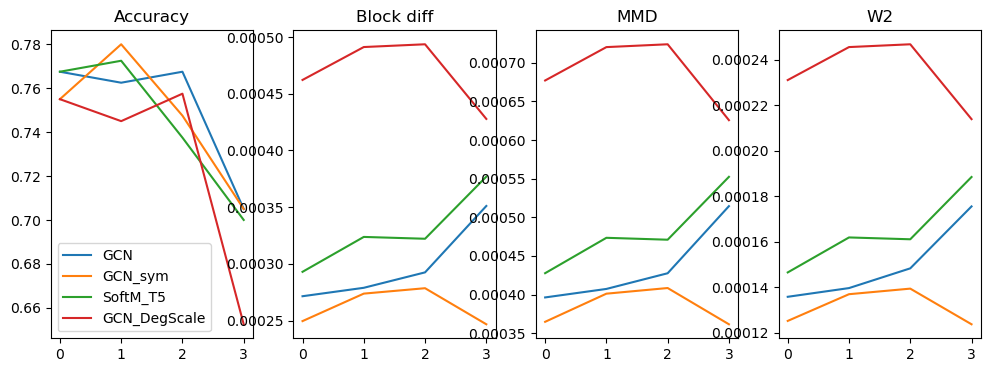

In [20]:
# new ntk - relu gcn, prbcd attack
prbcd_relu_gcn_ntk = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=True, norm_kernel=True)
plot_acc_measure(k)

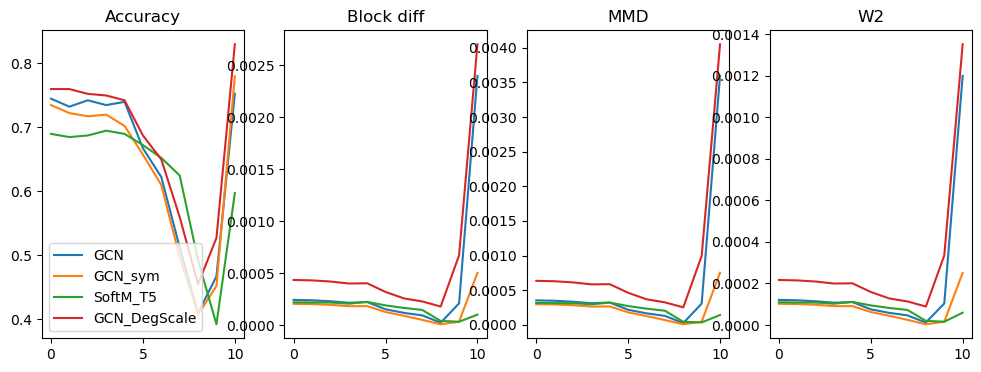

In [16]:
# new ntk - relu gcn, random attack
random_relu_gcn_ntk = ntk_dict.copy() 
k = get_results(ntk_dict, center_kernel=True, norm_kernel=True)
plot_acc_measure(k)